In [45]:
import numpy
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics.cluster import adjusted_rand_score

from tslearn.clustering import KShape
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import GlobalAlignmentKernelKMeans
from tslearn.metrics import sigma_gak, cdist_gak

import sys
import numpy as np
import yaml
from typing import Dict
from tqdm import tqdm

from adase.utils.pandas import read_df
from adase.utils.files import (directory_path,
                                get_raw_file,
                                get_all_files)
from adase.utils.pandas import write_df, read_df

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style="darkgrid")

In [5]:
def config(path) -> Dict:
    with open("{}config.yml".format(path), 'r') as ymlfile:
            cfg = yaml.load(ymlfile)
    return cfg

def download_dataset(cfg:Dict):
    
    raw_path = cfg.get('dataset').get('path_read_input')
    for file in tqdm(cfg.get('makedataset').get('files')):
        get_raw_file(raw_path, file)

def load_dataset(cfg:Dict):
    
    raw_path = cfg.get('dataset').get('path_read_input')
    
    dict_data: Dict = dict()

    for key, val in read_df(get_all_files(raw_path)).items():

        df_tmp = val.rename(columns={
                    'item': 'item_code',
                    'quantity_ecd': 'quantity',
                    'parent_item': 'parent_item_code',
                    'parent_quantity_ecd': 'parent_quantity'
                })

        if 'rpd' in df_tmp:
            first_element = sorted(df_tmp['rpd'].unique())[0]
            if first_element/1 != 1:
                df_tmp['rpd'] = df_tmp['rpd'] - (first_element-1)

        dict_data.update({key: df_tmp})
                
    return dict_data

cfg = config('../')
download_dataset(cfg)
data_dicts = load_dataset(cfg)

100%|██████████| 9/9 [00:00<00:00, 80.47it/s]


In [6]:
data_series = data_dicts.get('demand_out_encoded_stage_3')\
.set_index(['item_code', 'rpd','future_flag'])\
.sort_index().unstack("rpd", fill_value=0).fillna(0).values

mu, sigma = 0, 0.1 
#[:600]
#data = np.log1p(
data = np.log1p(data_series[:]) + np.abs(np.random.normal(mu, sigma, size=data_series.shape))

In [187]:
def plot_data(ks, X_train, y_pred, sz, n_clusters=3, centroid=False):
    
    plt.figure(figsize=(12,25))
    for yi in range(n_clusters):
        plt.subplot(n_clusters, 1, 1 + yi)
        for xx in X_train[y_pred == yi]:
            #, alpha=.2
            plt.plot(xx.ravel(), "k-")
            #,
        if centroid:
            plt.plot(ks.cluster_centers_[yi].ravel(), "r-")
        plt.xlim(0, sz)
        #plt.ylim(-4, 4)
        plt.title("Cluster %d" % (yi + 1))

    plt.tight_layout()
    plt.show()
    
def split_train_test(X, y, size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=size)
    
    return X_train, X_val, X_test, y_train, y_val, y_test
    
def normalize_data(data):
    numpy.random.shuffle(data)
    X_train = TimeSeriesScalerMeanVariance().fit_transform(data_series)
    sz = X_train.shape[1]
    
    return X_train, sz

def k_shape(data_series_normalized, n_clusters=3, verbose=True, seed=0):

    # Euclidean k-means
    ks = KShape(n_clusters=n_clusters, verbose=verbose, random_state=seed)
    
    return ks, ks.fit_predict(X_train)

def compute_scores(ks, X_train, y_pred, centroid=False):

    scores = []
    for yi in range(ks.n_clusters):
        tp_list = []
        for xx in X_train[y_pred == yi]:
            
            if centroid:
                predicted = ks.cluster_centers_[yi].ravel()
                actual = xx.ravel()
                score = adjusted_rand_score(actual, predicted)
                scores.append(score)
                
            else:
                predicted = xx.ravel()
                tp_list.append(predicted)
        
        if not centroid:
            half = len(tp_list)//2
            first_half = tp_list[:half]
            second_half = tp_list[half:]
            
            for i in np.arange(half):
                score = adjusted_rand_score(first_half[i], second_half[i])
                scores.append(score)
                            
            
    return scores
    #print('score: {0} -- actual: {1} -- predicted: {2}'.format(score, actual, predicted))

In [117]:
X_train, sz = normalize_data(data_series[:500])
ks, y_pred = k_shape(X_train, n_clusters=20)
#plot_data(X_train, y_pred, sz, 10)

0.053 --> 0.041 --> 0.037 --> 0.036 --> 0.034 --> 0.033 --> 0.033 --> 0.032 --> 0.033 --> 


In [118]:
scores = compute_scores(ks, X_train, y_pred)

In [122]:
np.mean(scores)

0.002279132592922573

{'whiskers': [<matplotlib.lines.Line2D at 0x7f29472c14a8>,
 'caps': [<matplotlib.lines.Line2D at 0x7f29472c1ba8>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f29472c1320>],
 'medians': [<matplotlib.lines.Line2D at 0x7f29472df2e8>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f29472df668>],
 'means': []}

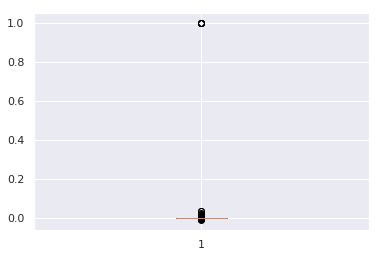

In [120]:
plt.boxplot(scores)

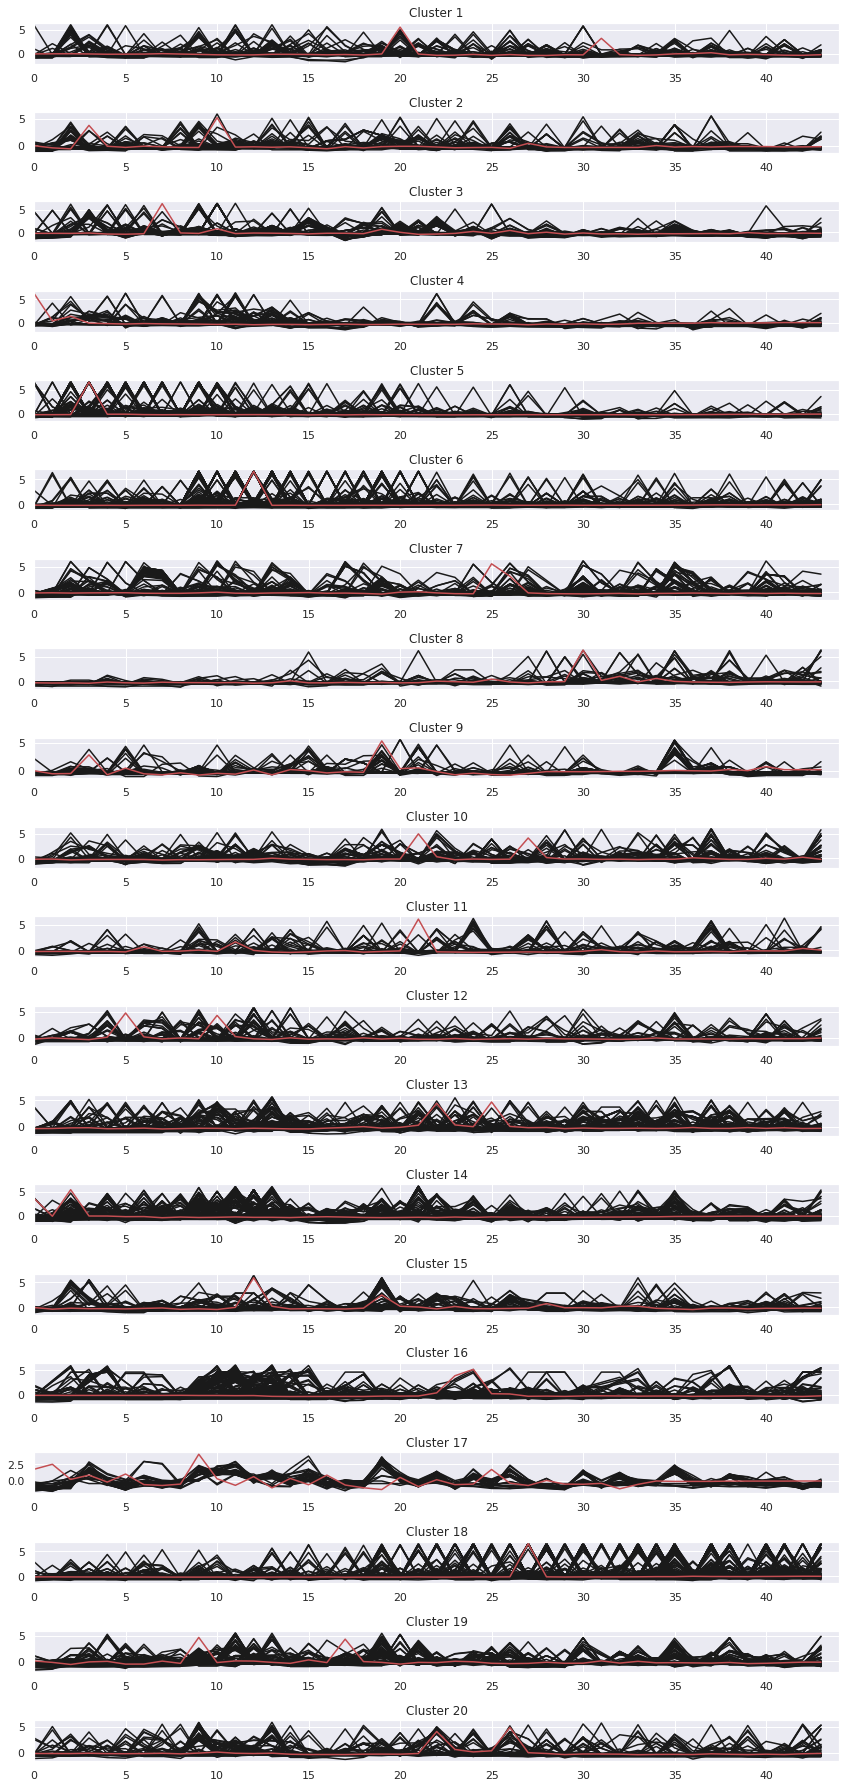

In [121]:
plot_data(ks, X_train, y_pred, sz, ks.n_clusters)

In [189]:
sz = X_train.shape[1]
gak_km = GlobalAlignmentKernelKMeans(n_clusters=20, 
                                     sigma=sigma_gak(X_train), 
                                     n_init=20, verbose=False, 
                                     random_state=seed)
y_pred = gak_km.fit_predict(X_train)



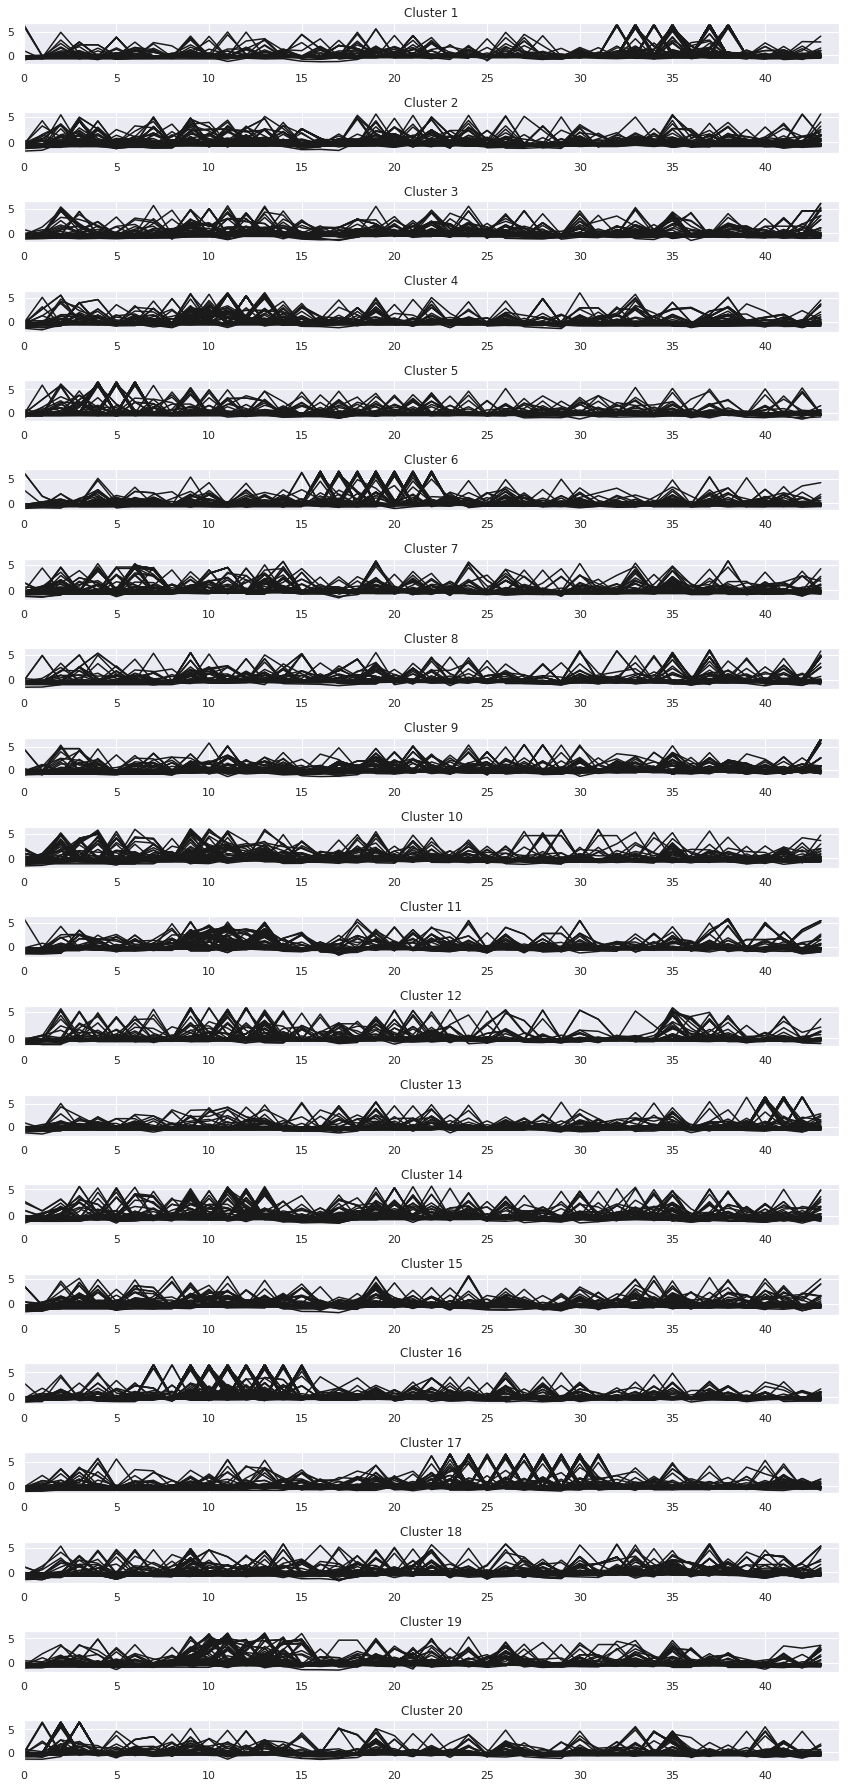

In [190]:
plot_data(gak_km, X_train, y_pred, sz, gak_km.n_clusters)

In [191]:
scores_km_shifted = compute_scores(gak_km, X_train, y_pred, centroid=False)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f2943c76d30>,
 'caps': [<matplotlib.lines.Line2D at 0x7f2943c7e470>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f2943c76ba8>],
 'medians': [<matplotlib.lines.Line2D at 0x7f2943c7eb70>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f2943c7eef0>],
 'means': []}

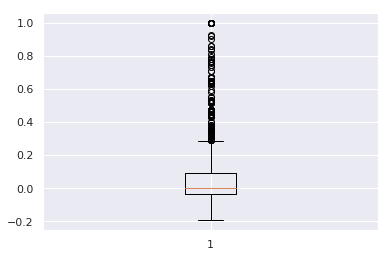

In [192]:
plt.boxplot(scores_km_shifted)

Soft-DTW k-means
252.999 --> 126.221 --> 130.236 --> 135.952 --> 136.151 --> 136.339 --> 136.310 --> 136.469 --> 136.403 --> 136.409 --> 136.369 --> 136.395 --> 136.351 --> 136.326 --> 136.307 --> 136.244 --> 136.234 --> 136.070 --> 136.068 --> 136.007 --> 136.006 --> 136.010 --> 136.018 --> 136.009 --> 135.983 --> 135.934 --> 135.939 --> 135.905 --> 135.902 --> 135.865 --> 135.864 --> 135.847 --> 135.831 --> 135.825 --> 135.826 --> 135.821 --> 135.822 --> 135.801 --> 135.776 --> 135.735 --> 135.702 --> 135.618 --> 135.599 --> 135.611 --> 135.612 --> 135.583 --> 135.580 --> 135.567 --> 135.532 --> 135.467 --> 


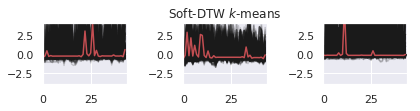

In [193]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler

print("Soft-DTW k-means")
sdtw_km = TimeSeriesKMeans(n_clusters=3, metric="softdtw", metric_params={"gamma_sdtw": .01},
                           verbose=True, random_state=seed)
y_pred = sdtw_km.fit_predict(X_train)

for yi in range(3):
    plt.subplot(3, 3, 7 + yi)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(sdtw_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    if yi == 1:
        plt.title("Soft-DTW $k$-means")

plt.tight_layout()
plt.show()

In [196]:
sdtw_km.cluster_centers_[0]

array([[-0.40582507],
       [-0.28071493],
       [ 0.39982673],
       [-0.33624383],
       [-0.22634066],
       [-0.30046285],
       [-0.29416821],
       [-0.29164811],
       [-0.29114586],
       [-0.2909541 ],
       [-0.29083928],
       [-0.29070676],
       [-0.29066552],
       [-0.29073761],
       [-0.2908592 ],
       [-0.29090994],
       [-0.29144721],
       [-0.29219536],
       [-0.29865019],
       [-0.25221551],
       [-0.37529689],
       [-0.06855341],
       [ 2.99975242],
       [ 0.01474517],
       [-0.26289132],
       [ 0.12269268],
       [ 4.01223267],
       [-0.23419803],
       [ 0.45690764],
       [-0.28784843],
       [-0.35172252],
       [-0.25419706],
       [-0.27709097],
       [-0.27739246],
       [-0.27803364],
       [-0.28009038],
       [-0.28959775],
       [-0.14319544],
       [-0.28709593],
       [-0.28151356],
       [-0.28983967],
       [-0.25285773],
       [-0.37259693],
       [ 0.56502968]])